# Quantum Maze Solver

## Import

In [9]:
from maze.maze import Graph
from maze.maze_solver import BFSSolver, QuantumMazeSolver, Path
from maze.maze_generator import PrimGenerator
from maze.maze_circuit import QuantumMazeCircuit, MazeOracle, MazeCircuitInfo, GroverDiffusionOperator
from collections import Counter

## Maze Generation

We provide utilities for building mazes and graphs in general. 

For maze generation, we implement **Prim’s algorithm**, which produces *perfect mazes* with a uniform structure.



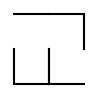

In [10]:
maze_generator = PrimGenerator()
maze = maze_generator.generate_maze(2, 2, (0, 0), (1, 1))
maze.show()

Graphs can be built from a given list of edges.

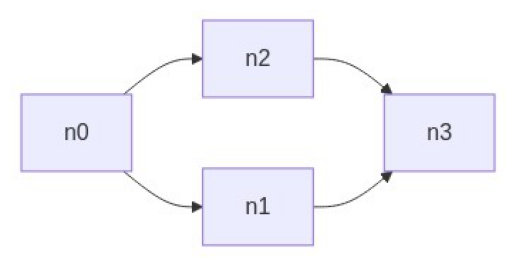

In [11]:
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
]
graph = Graph.from_edges(edges, start = 0, end = 3, bidirectional = False)
graph.show()

## Grover Iteration

A Grover iteration requires two key components:

- **Phase oracle**: Marks (or inverts the phase of) the desired quantum state.
- **Diffusion operator**: Amplifies the probability amplitude of the marked state.

Together, these steps increase the likelihood of measuring the target state after repeated iterations.


### Phase Oracle

The phase oracle we built for the maze pathfinding problem is based on two main ideas:

- The input is a sequence of nodes representing a path through the maze.
- To mark a state, we check that:
  - The path starts at the starting node and ends at the ending node.
  - Every pair of consecutive nodes forms a valid link in the maze.
  - For any sequence of three nodes, the first and last nodes are either different, or both equal to the ending node.

If all these conditions are satisfied, the oracle marks the corresponding quantum state.

To implement this, we use some ancilla qubits. Given that **N** is the maximum number of nodes in the path and **n** is the bit required to represent a node the oracle is built as follow:

- The first **N x n** qubits encode the node sequence of the path.
- The next **N − 1** ancilla qubits are used to check the valid link condition.
- The final **N − 2** ancilla qubits are used to check the three-node condition.

To avoid interference from these ancillas, we uncompute them after the phase flip.

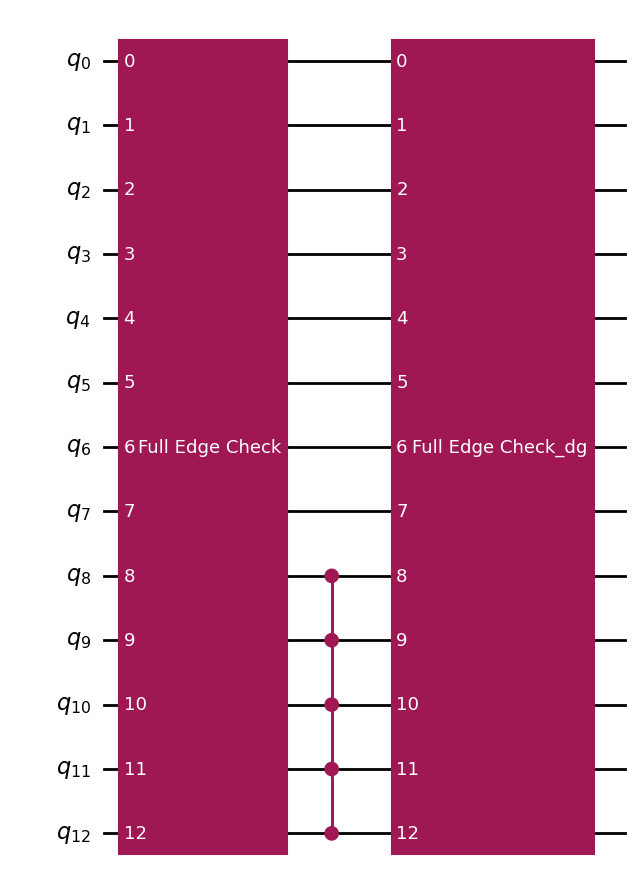

In [12]:
max_path_length = None # write a value to override the default that is: number of nodes in the graph - 1
maze_circuit_info = MazeCircuitInfo(graph, max_path_length)
maze_oracle = MazeOracle(maze_circuit_info, turn_back_check = True)
display(maze_oracle.draw('mpl'))
#display(maze_oracle.decompose(reps = 2).draw('mpl')) 

### Diffusion Operator

The diffusion operator amplifies the probability of the marked state by reflecting the quantum state about the equal superposition state $|s\rangle$. This corresponds to inverting each amplitude around the average amplitude of the current state $|\psi\rangle$.

Given the equal superposition state:  
$|s\rangle = \frac{1}{\sqrt{N}} \sum_x |x\rangle$, where $N$ is the total number of basis states.

The diffusion operator is defined as:  
$D = 2 |s\rangle \langle s| - I_N$, where $I_N$ is the identity on $N$ qubits.

Since $|s\rangle = H^{\otimes N} |0\rangle$ and $I_N = H^{\otimes N} I_N H^{\otimes N}$, we can write:  
$D = H^{\otimes N} (2 |0\rangle \langle 0| - I_N) H^{\otimes N}$,
where $2 |0\rangle \langle 0| - I_N = X^{\otimes N} CZ X^{\otimes N}$.



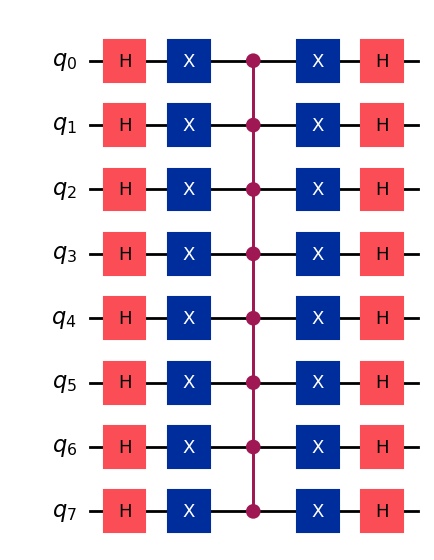

In [13]:
num_qubits = maze_circuit_info.num_qubits_in_max_path
diffusion_operator = GroverDiffusionOperator(num_qubits)
diffusion_operator.draw('mpl')

## Maze Solver

Put it all together, after applying the Grover iterations the correct number of times, we we succeed in obtaining the desired solution.


In [14]:
quantum_solver = QuantumMazeSolver()
classical_solver = BFSSolver()

def most_frequent_solution_path_in(graph: Graph) -> Path:
    result = quantum_solver.run(graph, shots=10000)
    ordered_solution_with_frequency = sorted(Counter(result).items(), key=lambda x: -x[1])
    [print(k.remove_cycles(), ':', v) for k, v in ordered_solution_with_frequency]
    return ordered_solution_with_frequency[0][0].remove_cycles()

for maze we can build the following quantum circuit

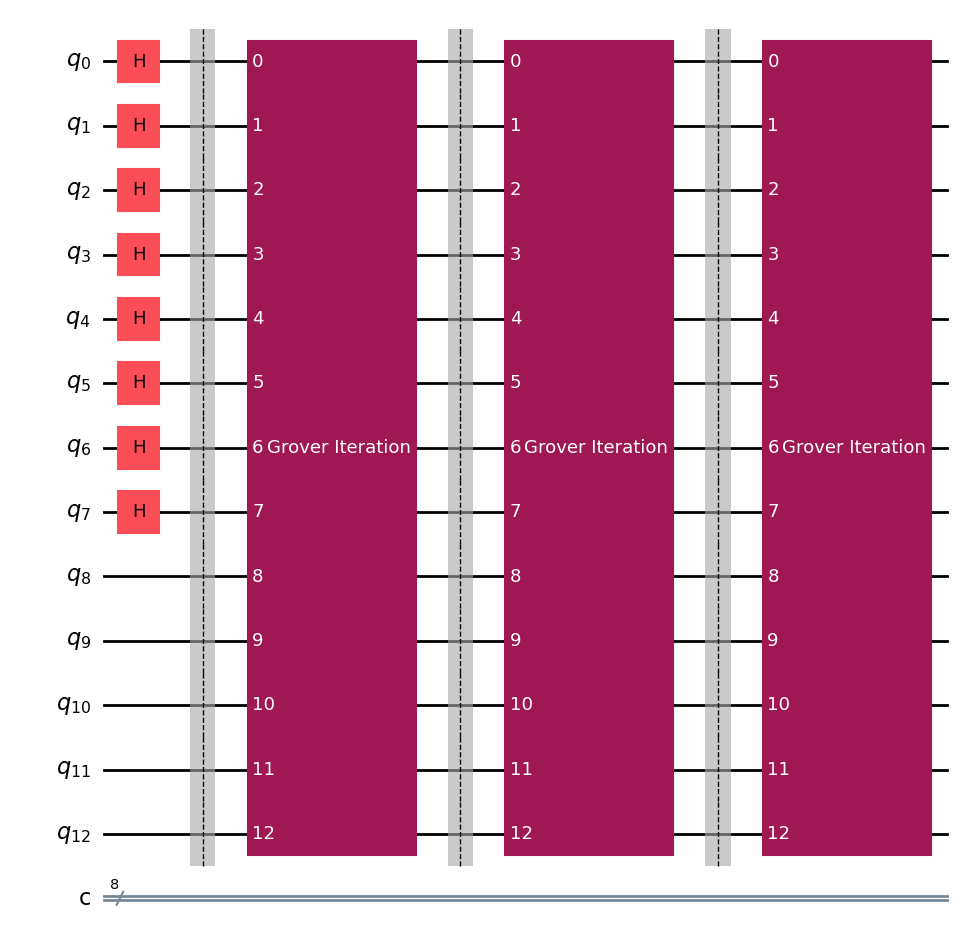

In [15]:
maze_qc = QuantumMazeCircuit(maze, turn_back_check=True) # custom max_path_length can be set
maze_qc.decompose(reps = 0).draw('mpl')


and then obtain the solution with quantum solver

[0 -> 1 -> 3] : 1812
[1 -> 0] : 49
[2] : 48
[2 -> 1] : 47
[1] : 46
[3 -> 2] : 44
[3 -> 1 -> 2] : 44
[1 -> 3] : 43
[2 -> 1 -> 0] : 43
[1 -> 2 -> 0 -> 3] : 42
[2 -> 3 -> 1 -> 0] : 42
[2] : 42
[3] : 41
[0 -> 1 -> 3] : 41
[0 -> 1 -> 2] : 41
[3] : 41
[2 -> 1] : 41
[3 -> 2 -> 1 -> 0] : 40
[0 -> 2 -> 1] : 40
[2 -> 3] : 39
[1] : 39
[3 -> 1] : 39
[3 -> 0] : 39
[3 -> 0 -> 2 -> 1] : 39
[0 -> 1] : 39
[3 -> 2] : 39
[1 -> 3] : 39
[2] : 39
[3 -> 0] : 39
[2 -> 0] : 38
[3] : 38
[2 -> 0] : 37
[3 -> 0] : 37
[1 -> 3 -> 0] : 37
[2 -> 0] : 37
[1] : 37
[0] : 37
[1 -> 0 -> 2 -> 3] : 37
[0 -> 2 -> 3] : 37
[3 -> 0] : 37
[0 -> 2 -> 3] : 37
[1 -> 2 -> 0] : 37
[2 -> 1] : 37
[2 -> 3] : 37
[1 -> 2 -> 0] : 37
[0] : 37
[0 -> 2 -> 1] : 37
[0 -> 2] : 37
[2 -> 0] : 37
[3 -> 0 -> 2] : 36
[3] : 36
[2 -> 1 -> 3] : 36
[1] : 36
[3] : 36
[2 -> 3] : 36
[2 -> 3 -> 1] : 36
[3] : 36
[2] : 36
[3] : 36
[0] : 36
[3 -> 2] : 36
[3 -> 0] : 36
[1] : 35
[1] : 35
[0 -> 3 -> 1] : 35
[0] : 35
[2 -> 1 -> 0 -> 3] : 35
[0 -> 2] : 35
[3] : 35
[2

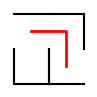

In [16]:
maze.show(most_frequent_solution_path_in(maze_qc))

and compare with classical solver

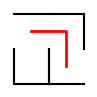

In [17]:
maze.show(classical_solver.solve(maze))

for graph we can build the following quantum circuit

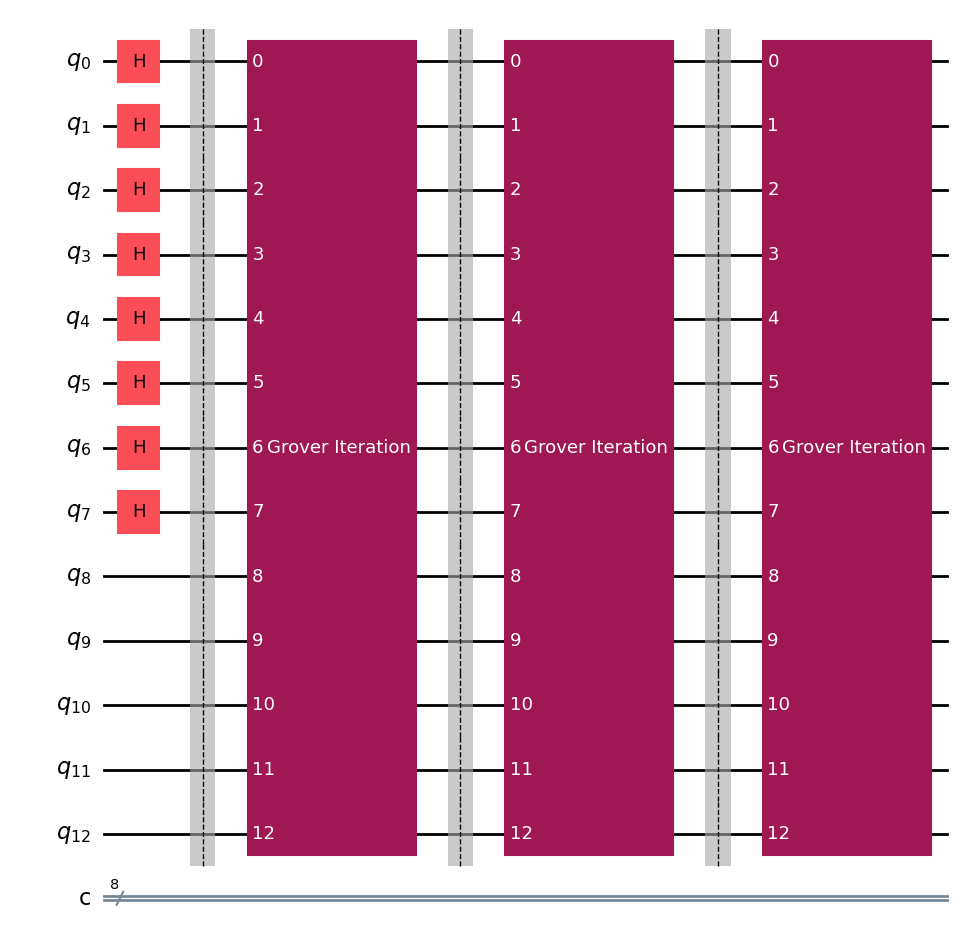

In [18]:
graph_qc = QuantumMazeCircuit(graph, turn_back_check=True) # custom max_path_length can be set
graph_qc.decompose(reps = 0).draw('mpl')

and then obtain the solution with quantum solver

[0 -> 1 -> 3] : 1695
[0 -> 2 -> 3] : 1672
[2 -> 1] : 50
[2 -> 1] : 41
[0] : 39
[2 -> 0] : 39
[2 -> 0 -> 1] : 38
[1] : 38
[1 -> 0] : 37
[1] : 37
[1 -> 0] : 36
[2 -> 1 -> 0] : 36
[3 -> 1] : 35
[0 -> 2] : 35
[0] : 35
[1 -> 3 -> 2] : 34
[1 -> 0] : 34
[0 -> 3 -> 2] : 34
[0 -> 2 -> 1 -> 3] : 34
[1 -> 3] : 34
[0 -> 1 -> 2 -> 3] : 34
[1 -> 0] : 34
[3 -> 1 -> 2] : 34
[2 -> 1 -> 3] : 34
[0 -> 1 -> 2] : 33
[3 -> 0] : 33
[1 -> 2] : 33
[3] : 33
[1 -> 0 -> 2] : 33
[1 -> 0 -> 3] : 33
[2 -> 3] : 33
[3] : 33
[1 -> 3] : 33
[3 -> 1 -> 2 -> 0] : 33
[3] : 32
[3 -> 1 -> 0] : 32
[3 -> 1] : 32
[1 -> 3] : 31
[0 -> 1 -> 3] : 31
[2] : 31
[0] : 31
[0 -> 2 -> 3] : 31
[0] : 31
[0 -> 1] : 31
[0 -> 2 -> 3] : 31
[2 -> 1] : 31
[0 -> 3] : 30
[0] : 30
[3 -> 2 -> 0] : 30
[2] : 30
[1] : 30
[0 -> 1] : 30
[1 -> 0 -> 3] : 30
[1] : 30
[3 -> 0 -> 2] : 30
[2 -> 1] : 30
[0 -> 2] : 29
[1] : 29
[2 -> 1 -> 0] : 29
[1 -> 2] : 29
[0 -> 2] : 29
[3 -> 0] : 29
[2 -> 1] : 29
[3 -> 2] : 29
[3 -> 1] : 29
[3 -> 1] : 29
[2] : 29
[3 -> 2 -> 0]

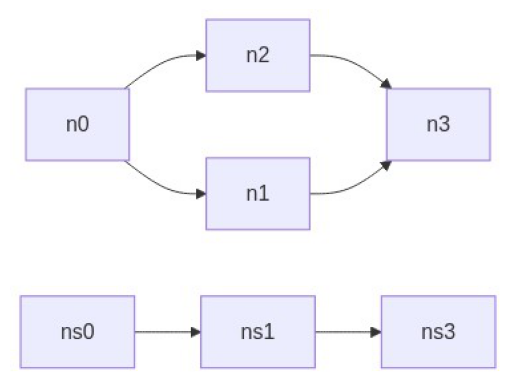

In [19]:
graph.show(most_frequent_solution_path_in(graph_qc))

and compare with classical solver

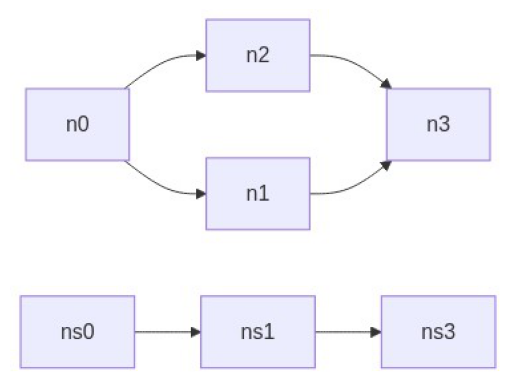

In [20]:
graph.show(classical_solver.solve(graph))